# Example Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"


def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

In [3]:
import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


In [4]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
stocks_df = pd.read_csv(stocks_file_path)
stocks_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016731,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741028,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361347,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393185,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705986,70.501671,70.501671,69.648827,69.974915,4073337.0


In [5]:
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
index_df = pd.read_csv(index_file_path)
index_df.head()

,Date,S&P500
0,2014-10-27,1961.63
1,2014-10-28,1985.05
2,2014-10-29,1982.30
3,2014-10-30,1994.65
4,2014-10-31,2018.05


In [6]:
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)
companies_df = pd.read_csv(companies_file_path)
companies_df.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,231.41,3518380900352,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.064652
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,141.54,3471975907328,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.063800
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,428.15,3183055470592,1.294330e+11,0.152,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058491
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,165.27,2013319135232,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.036996
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,166.99,2013315072000,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.036996


In [7]:
all_symbols = companies_df["Symbol"].unique()
print(all_symbols)

['AAPL' 'NVDA' 'MSFT' 'GOOGL' 'GOOG' 'AMZN' 'META' 'BRK-B' 'TSLA' 'LLY'
 'AVGO' 'WMT' 'JPM' 'V' 'XOM' 'UNH' 'ORCL' 'MA' 'PG' 'JNJ' 'COST' 'HD'
 'ABBV' 'BAC' 'NFLX' 'KO' 'CRM' 'CVX' 'MRK' 'TMUS' 'AMD' 'PEP' 'ACN' 'LIN'
 'CSCO' 'TMO' 'WFC' 'IBM' 'MCD' 'ADBE' 'BX' 'PM' 'ABT' 'GE' 'NOW' 'AXP'
 'MS' 'QCOM' 'TXN' 'CAT' 'DHR' 'ISRG' 'VZ' 'NEE' 'DIS' 'INTU' 'AMGN' 'RTX'
 'UBER' 'PFE' 'GS' 'T' 'CMCSA' 'SPGI' 'AMAT' 'LOW' 'UNP' 'BLK' 'BKNG'
 'PGR' 'HON' 'SYK' 'ETN' 'LMT' 'SCHW' 'TJX' 'BSX' 'KKR' 'ANET' 'VRTX'
 'COP' 'MU' 'C' 'PANW' 'CB' 'NKE' 'MDT' 'ADP' 'FI' 'ADI' 'UPS' 'PLD' 'DE'
 'GILD' 'SBUX' 'MMC' 'BMY' 'HCA' 'AMT' 'REGN' 'SO' 'LRCX' 'ELV' 'BA'
 'INTC' 'PLTR' 'ICE' 'MDLZ' 'DUK' 'SHW' 'KLAC' 'TT' 'CI' 'EQIX' 'ZTS' 'WM'
 'MCO' 'MO' 'CTAS' 'DELL' 'GD' 'APH' 'PYPL' 'ABNB' 'CEG' 'CME' 'AON'
 'WELL' 'CMG' 'PH' 'GEV' 'CL' 'MSI' 'SNPS' 'TDG' 'ITW' 'USB' 'NOC' 'PNC'
 'MAR' 'ECL' 'CRWD' 'APD' 'CARR' 'CVS' 'EOG' 'CDNS' 'MMM' 'TGT' 'BDX'
 'ORLY' 'FCX' 'FDX' 'NEM' 'MCK' 'SPG' 'CSX' 'RSG' 'WMB' 'AJG' 'AF

In [8]:
technology_symbols_sorted_by_marketcap = companies_df[
    companies_df["Sector"] == "Technology"
].sort_values(by="Marketcap", ascending=False)["Symbol"]

top_ten_technology_symbols = technology_symbols_sorted_by_marketcap[:10]

print(top_ten_technology_symbols)

0     AAPL
1     NVDA
2     MSFT
10    AVGO
16    ORCL
26     CRM
30     AMD
32     ACN
34    CSCO
37     IBM
Name: Symbol, dtype: object


In [9]:
dates = stocks_df["Date"].unique()
print(dates)
print(dates.shape)

['2010-01-04' '2010-01-05' '2010-01-06' ... '2024-10-23' '2024-10-24'
 '2024-10-25']
(3729,)


In [10]:
def get_individual_stock_df(df, symbol):
    stock_df = df[df["Symbol"] == symbol].copy()
    return stock_df


def get_individual_stock_numpy(df, symbol):
    stock_df = get_individual_stock_df(df, symbol)
    stock_array = stock_df[["Low", "High"]].to_numpy()
    return stock_array

In [44]:
# Inputs
target_symbol = "AAPL"
n_days_history = 1
n_days_forward = 2

# Get the targets for prediction
target_stock_array = get_individual_stock_numpy(stocks_df, target_symbol)

target_stock_low = target_stock_array[:, 0]
target_stock_high = target_stock_array[:, 1]

y_targets_low = target_stock_low[(n_days_history + n_days_forward - 1) :]
y_targets_high = target_stock_high[(n_days_history + n_days_forward - 1) :]

# Get the feature array
# predictor_symbols = top_ten_technology_symbols.tolist()
predictor_symbols = ["AAPL"]

n_predictor_symbols = len(predictor_symbols)
n_features = n_predictor_symbols * n_days_history * 5

predictor_stock_arrays = []

# For each of the top ten stocks in our list, convert it to a numpy array
for symbol in predictor_symbols:
    predictor_stock_numpy = get_individual_stock_numpy(stocks_df, symbol)
    predictor_stock_arrays.append(predictor_stock_numpy)

# Concatenate the numpy arrays into a wide array to predict from
prediction_array = np.concatenate(predictor_stock_arrays, axis=1)

flat_samples = []

# Create the array of historical values to be used for predictions
total_days = dates.shape[0]
for start_idx in np.arange(total_days - n_days_history - n_days_forward + 1):
    end_idx = start_idx + n_days_history
    square_sample = prediction_array[start_idx:end_idx, :]
    flat_sample = square_sample.flatten()
    flat_samples.append(flat_sample)

x_features = np.vstack(flat_samples)

print(x_features.shape)
print(y_targets_low.shape)
print(y_targets_high.shape)

(3727, 2)
(3727,)
(3727,)


In [45]:
# x_indices = np.arange(len(x_features[:,0]))
# plt.figure(figsize=(8, 6))
# plt.scatter(x_indices, x_features[:,0], marker='x')
# plt.scatter(x_indices, y_targets_low, marker='o')

# x_indices = np.arange(len(x_features[:,1]))
# plt.figure(figsize=(8, 6))
# plt.scatter(x_indices, x_features[:,1], marker='x')
# plt.scatter(x_indices, y_targets_high, marker='o')

In [46]:
x_features[0]

array([7.58500004, 7.66071415])

In [47]:
y_targets_low[0], y_targets_high[0]

(np.float64(7.526785850524902), np.float64(7.68678617477417))

In [48]:
train_split = 0.8
n_train_days = int(total_days * train_split)

x_train = x_features[:n_train_days, :]
x_test = x_features[n_train_days:, :]

y_low_train = y_targets_low[:n_train_days]
y_low_test = y_targets_low[n_train_days:]

y_high_train = y_targets_high[:n_train_days]
y_high_test = y_targets_high[n_train_days:]

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [50]:
# Initialize the Random Forest model
# low_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)
low_model = LinearRegression()

# Fit the model to the training data
low_model.fit(x_train, y_low_train)

y_low_train_hat = low_model.predict(x_train)

low_mse_train = mean_squared_error(y_low_train, y_low_train_hat)

print("Training MSE for low value prediction:", low_mse_train)

Training MSE for low value prediction: 1.880700214092638


In [51]:
# Make predictions on the test set
y_low_test_hat = low_model.predict(x_test)

# Calculate the mean squared error for evaluation
low_mse_test = mean_squared_error(y_low_test, y_low_test_hat)

print("Mean Squared Error:", low_mse_test)

Mean Squared Error: 16.73065566552733


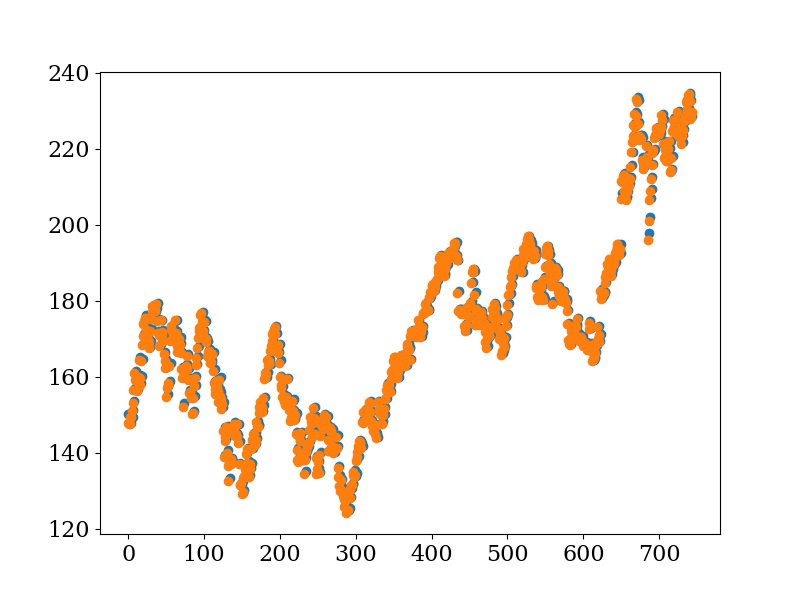

In [52]:
x_indices = np.arange(len(y_low_test_hat))
plt.figure(figsize=(8, 6))
plt.scatter(x_indices, y_low_test_hat)
plt.scatter(x_indices, y_low_test)